# Importing Libraries

In [1]:
import modAL

In [2]:
import numpy as np
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
import alipy

In [4]:
import alipy
from alipy import ToolBox
from alipy.query_strategy.query_labels import QueryInstanceUncertainty
from alipy.index.index_collections import MultiLabelIndexCollection

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import random
from scipy.stats import bernoulli, multivariate_normal
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import time 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from joblib import Parallel, delayed
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import warnings
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.model_selection._search")
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


# Synthetic Data

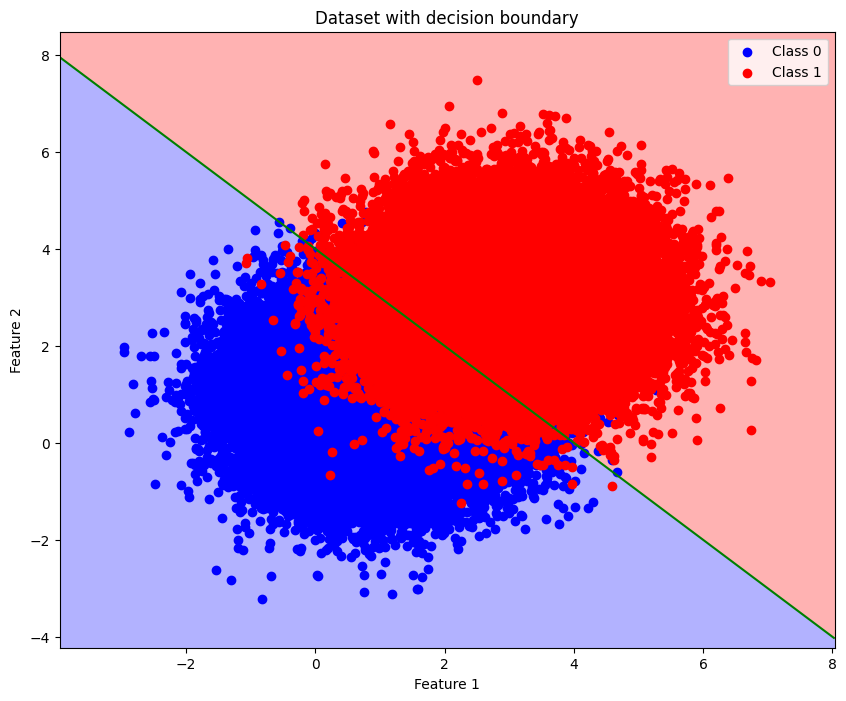

In [6]:
def eta1(x,p=1/2,mean0=np.array([1,1]), mean1=np.array([3,3]), cov0=np.array([[1, 0], [0, 1]]), cov1=np.array([[1, 0], [0, 1]])):
    eta= p * multivariate_normal.pdf(x, mean=mean1, cov=cov1) / ((p * multivariate_normal.pdf(x, mean=mean1, cov=cov1) + (1 - p) * multivariate_normal.pdf(x, mean=mean0, cov=cov0)))
    return eta


def generate_data(n_samples=100000, n_features=2, mean0=np.array([1,1]), mean1=np.array([3,3]), cov0=np.array([[1, 0], [0, 1]]), cov1=np.array([[1, 0], [0, 1]])):
    Y = bernoulli.rvs(0.5, size=n_samples)
    X = np.zeros((n_samples, n_features))
    
    
    for i in range(n_samples):
        if Y[i] == 0:
            X[i, :] = multivariate_normal.rvs(mean=mean0, cov=cov0)
        else:
            X[i, :] = multivariate_normal.rvs(mean=mean1, cov=cov1)
    
    return X, Y




X, Y = generate_data()


x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]


Z = np.array([eta1(point) for point in grid])
Z = Z.reshape(xx.shape)


plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=['blue', 'red'])
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='red', label='Class 1')
plt.contour(xx, yy, Z, levels=[0.5], colors='green')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset with decision boundary')
plt.show()

# Classification

## My Algorithm

### Rejection

In [8]:
def score_function(X, eta):
    probs = eta.predict_proba(X)[:, 1]
    scores = np.maximum(probs, 1 - probs)
    return scores


def find_threshold(Ak, eta, p):
    
    
    scores = score_function(Ak, eta)

    threshold = np.quantile(scores, p)
    
    return threshold

def active_learning_with_rejection_lr(data, X_train, Y_train, beta=1, N1=500, d=2, c=1.5, M=100):
    N = [int(np.sqrt(N1))]
    A = [data[0]]
    epsilon = [1]
    eta = []
    lambda_ = []
    D = [[]]

    B = N[0]
    L = [data[1]]
    k = 1
    time_taken=[]

    # Ensure both classes are present in the initial sample
    while True:
        indices = np.random.choice(len(X_train), size=N[0], replace=False)
        X0, Y0 = X_train[indices], Y_train[indices]
        if len(np.unique(Y0)) == 2:
            break

    eta_0 = LogisticRegression()
    eta_0.fit(X0, Y0)
    eta.append(eta_0)
    D[0] = list(zip(X0, Y0))

    delta = 0.46
    i = 1
    N.append(int(c * N[i - 1]))
    epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
    N_k = N[1]
    e_k = epsilon[1]
    lambda_.append(1)

    while B + np.floor(N_k * e_k) <= N1:
        t1 = time.time()

        indices1 = np.random.choice(len(A[i - 1]), size=M, replace=False)
        D_U = [A[i - 1][j] for j in indices1]
        lambda_.append(find_threshold(D_U, eta[i - 1], e_k))
        t2 = time.time()
        scores = score_function(np.array(A[i - 1]), eta[i - 1])
        mask = scores <= lambda_[i]
        A.append(np.array(A[i - 1])[mask].tolist())
        L.append(np.array(L[i - 1])[mask].tolist())

        D_U_set = set(map(tuple, D_U))
        A_next_filtered = [point for point in A[i] if tuple(point) not in D_U_set]
        L_next_filtered = [L[i][j] for j, point in enumerate(A[i]) if tuple(point) not in D_U_set]

        # Ensure both classes are present in the sample
        while True:
            sample_size = min(len(L_next_filtered), int(np.floor(N_k * e_k)))
            indices = np.random.choice(len(L_next_filtered), size=sample_size, replace=False)
            d_points = [(A_next_filtered[h], L_next_filtered[h]) for h in indices]
            if len(np.unique([label for _, label in d_points])) == 2:
                break

        D.append(d_points)

        t3 = time.time()

        X_i = [pair[0] for pair in D[i]]
        Y_i = [pair[1] for pair in D[i]]
        t4 = time.time()
        eta_i = LogisticRegression()
        eta_i.fit(X_i, Y_i)
        eta.append(eta_i)
        t5 = time.time()
        B += np.floor(N_k * e_k)
        i += 1
        N.append(int(c * N[i - 1]))
        epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
        N_k = N[i]
        e_k = epsilon[i]
        t6 = time.time()
        time_taken.append([t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t6-t1])

    return epsilon, A, eta, time_taken

def label_points(X_test, A, eta):
    A_arrays = [np.array(sublist) for sublist in A]
    eta_values = np.zeros(len(X_test))
    labels = np.zeros(len(X_test), dtype=int)

    for j in range(len(eta) - 1):
        mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
        
        if not np.any(mask_j):
            continue

        eta_values[mask_j] += eta[j].predict_proba(X_test[mask_j])[:, 1]

    mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
    
    if np.any(mask_last):
        eta_values[mask_last] += eta[-1].predict_proba(X_test[mask_last])[:, 1]

    labels = (eta_values >= 0.5).astype(int)
    return eta_values, labels


In [9]:
data=[X,Y]
X_train, X_test, Y_train, Y_test = train_test_split(data[0], data[1], test_size=0.3, random_state=42)       
        
epsilon1, A1, eta1, time_taken1 = active_learning_with_rejection_lr(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
eta_values1, labels1 = label_points(X_test, A1, eta1)
accuracy_al1 = accuracy_score(Y_test, labels1)
print(accuracy_al1)


0.9155666666666666


### QBC

In [10]:
def vote_entropy(committee, X):
   
    committee_votes = np.array([clf.predict(X) for clf in committee])
    bincounts = np.apply_along_axis(np.bincount, 0, committee_votes, minlength=2)
    probabilities = bincounts / len(committee)
    vote_entropy = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=0)
    return vote_entropy

def query_by_committee_sampling(committee, X, n_instances=10):
    entropy = vote_entropy(committee, X)
    query_indices = np.argsort(entropy)[-n_instances:]
    return query_indices


def fit_classifier(clf, X, y):
    return clf.fit(X, y)



def active_learning_with_rejection_QBC(data, X_train, Y_train, beta=1, N1=200, d=2, c=1.1, M=100):
    N = [int(np.sqrt(N1))]
    A = [data[0]]
    epsilon = [1]
    eta = []
    lambda_ = []
    D = [[]]

    B = N[0]
    L = [data[1]]
    k = 1
    time_taken=[]

    
    
    classifier_types = [
        RandomForestClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
        SVC(probability=True, random_state=42),
        LogisticRegression(random_state=42),
        DecisionTreeClassifier(random_state=42)
    ]
    
    while True:
        indices = np.random.choice(len(X_train), size=N[0], replace=False)
        X0, Y0 = X_train[indices], Y_train[indices]
        if len(np.unique(Y0)) == 2:
            break
    committee = Parallel(n_jobs=-1)(
    delayed(fit_classifier)(clf, X0, Y0) for clf in classifier_types)

    eta.append(committee)

    D[0] = list(zip(X0, Y0))

    delta = 0.46
    i = 1
    N.append(int(c * N[i - 1]))
    epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
    N_k = N[1]
    e_k = epsilon[1]
    lambda_.append(1)

    while B + np.floor(N_k * e_k) <= N1:
        t1 = time.time()

        indices1 = query_by_committee_sampling(eta[i - 1], A[i - 1], M)
        D_U = [A[i - 1][j] for j in indices1]
        t=[]
        for k in range(5):
            t.append(find_threshold(D_U, eta[i - 1][k], e_k))

        
        lambda_.append(np.mean(t))
        t2 = time.time()
        scores = score_function(np.array(A[i - 1]), eta[i - 1][0])
        mask = scores <= lambda_[i]
        A.append(np.array(A[i - 1])[mask].tolist())
        L.append(np.array(L[i - 1])[mask].tolist())

        D_U_set = set(map(tuple, D_U))
        A_next_filtered = [point for point in A[i] if tuple(point) not in D_U_set]
        L_next_filtered = [L[i][j] for j, point in enumerate(A[i]) if tuple(point) not in D_U_set]

        # Ensure both classes are present in the sample
        while True:
            sample_size = min(len(L_next_filtered), int(np.floor(N_k * e_k)))
            indices = np.random.choice(len(L_next_filtered), size=sample_size, replace=False)
            d_points = [(A_next_filtered[h], L_next_filtered[h]) for h in indices]
            if len(np.unique([label for _, label in d_points])) == 2:
                break

        D.append(d_points)

        t3 = time.time()

        X_i = [pair[0] for pair in D[i]]
        Y_i = [pair[1] for pair in D[i]]
        t4 = time.time()
        
        classifier_types = [
        RandomForestClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
        SVC(probability=True, random_state=42),
        LogisticRegression(random_state=42),
        DecisionTreeClassifier(random_state=42)]
    

        new_committee = Parallel(n_jobs=-1)(
        delayed(fit_classifier)(clf, X_i, Y_i) for clf in classifier_types)

        eta.append(new_committee)

        t5 = time.time()
        B += np.floor(N_k * e_k)
        i += 1
        N.append(int(c * N[i - 1]))
        epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
        N_k = N[i]
        e_k = epsilon[i]
        t6 = time.time()
        time_taken.append([t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t6-t1])

    return epsilon, A, eta, time_taken


def label_points_QBC(X_test, A, eta):
    A_arrays = [np.array(sublist) for sublist in A]
    eta_values = np.zeros(len(X_test))
    labels = np.zeros(len(X_test), dtype=int)
    
    for j in range(len(eta) - 1):
        mask_j = np.all(np.isin(X_test, A_arrays[j]), axis=1) & ~np.all(np.isin(X_test, A_arrays[j + 1]), axis=1)
        if not np.any(mask_j):
            continue
        eta_values[mask_j] += np.mean([clf.predict_proba(X_test[mask_j])[:, 1] for clf in eta[j]], axis=0)
    
    mask_last = np.all(np.isin(X_test, A_arrays[-1]), axis=1)
    if np.any(mask_last):
        eta_values[mask_last] += np.mean([clf.predict_proba(X_test[mask_last])[:, 1] for clf in eta[-1]], axis=0)
    labels = (eta_values >= 0.5).astype(int)
    
    return eta_values, labels


### Uncertainty Sampling

In [11]:
def uncertainty_sampling(model, X, n_instances=10):
    #print(X.shape)
    
    probs = model.predict_proba(X)[:, 1]
    margins = np.abs(probs - 0.5)
    query_indices = np.argsort(margins)[-n_instances:]
    return query_indices

def active_learning_with_rejection_US_lr(data, X_train, Y_train, beta=1, N1=200, d=2, c=1.1, M=100):
    N = [int(np.sqrt(N1))]
    A = [data[0]]
    epsilon = [1]
    eta = []
    lambda_ = []
    D = [[]]

    B = N[0]
    L = [data[1]]
    k = 1
    time_taken=[]
    while True:
        indices = np.random.choice(len(X_train), size=N[0], replace=False)
        X0, Y0 = X_train[indices], Y_train[indices]
        if len(np.unique(Y0)) == 2:
            break
    
    eta_0 = LogisticRegression()
    eta_0.fit(X0, Y0)
    eta.append(eta_0)

    D[0] = list(zip(X0, Y0))

    delta = 0.46
    i = 1
    N.append(int(c * N[i - 1]))
    epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
    N_k = N[1]
    e_k = epsilon[1]
    lambda_.append(1)

    while B + np.floor(N_k * e_k) <= N1:

        t1 = time.time()

        D_U_indices = uncertainty_sampling(eta[i - 1], A[i - 1], M)
        D_U = [A[i - 1][j] for j in D_U_indices]
        lambda_.append(find_threshold(D_U, eta[i - 1], e_k))
        

        t2 = time.time()
        scores = score_function(np.array(A[i - 1]), eta[i - 1])
        mask = scores <= lambda_[i]
        A.append(np.array(A[i - 1])[mask].tolist())
        L.append(np.array(L[i - 1])[mask].tolist())

        
        D_U_set = set(map(tuple, D_U))
        
        A_next_filtered = [point for point in A[i] if tuple(point) not in D_U_set]
        L_next_filtered = [L[i][j] for j, point in enumerate(A[i]) if tuple(point) not in D_U_set]
        
        while True:
            sample_size = min(len(L_next_filtered), int(np.floor(N_k * e_k)))
            indices = np.random.choice(len(L_next_filtered), size=sample_size, replace=False)
            d_points = [(A_next_filtered[h], L_next_filtered[h]) for h in indices]
            if len(np.unique([label for _, label in d_points])) == 2:
                break






        
        t3 = time.time()
        #print(N_k, e_k, np.floor(N_k * e_k),len(L[i]))
        
        D.append(d_points)

        X_i = [pair[0] for pair in D[i]]
        Y_i = [pair[1] for pair in D[i]]
        t4 = time.time()
        eta_i = LogisticRegression()
        eta_i.fit(X_i, Y_i)
        eta.append(eta_i)

        t5 = time.time()
        B += np.floor(N_k * e_k)
        i += 1
        N.append(int(c * N[i - 1]))
        epsilon.append(min(0.85, (np.log(N1 / delta)) * (np.log(N1)) * ((N[i - 1]) ** (-beta / (2 * beta + d)))))
        N_k = N[i]
        e_k = epsilon[i]

        t6 = time.time()
        time_taken.append([t2-t1, t3-t2, t4-t3, t5-t4, t6-t5, t6-t1])

    return epsilon, A, eta, time_taken


## modAL

In [12]:
classifier =  LogisticRegression()
n_initial=20
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial, y_initial = X_train[initial_idx], Y_train[initial_idx]

learner = ActiveLearner(
    estimator=classifier,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

In [13]:
n_queries = 380
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X)
    #print(query_idx)
    learner.teach(X[query_idx], Y[query_idx])

# Evaluate the learner
print(f'Accuracy after {n_queries} queries: {learner.score(X_test, Y_test)}')


Accuracy after 380 queries: 0.8910333333333333


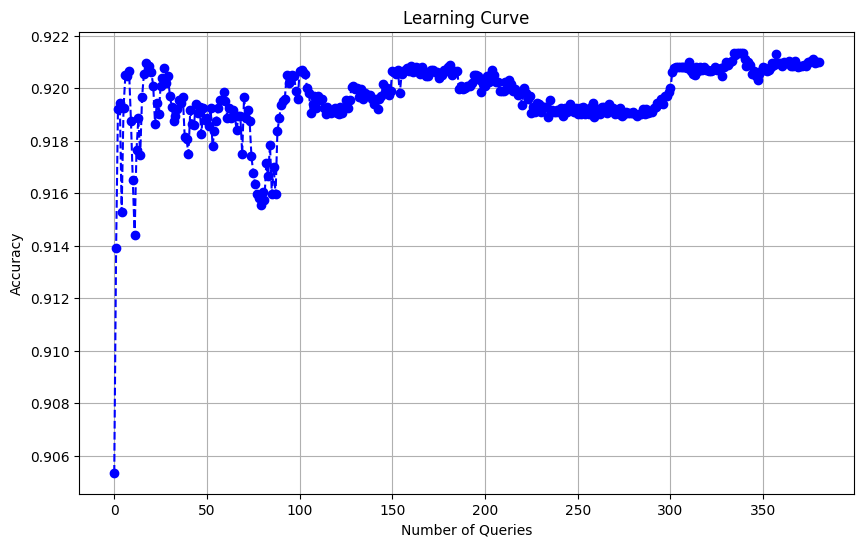

Final Accuracy after 380 queries: 0.921


In [8]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the base classifier
classifier = LogisticRegression()

# Select the initial training data randomly
n_initial = 20
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]


learner = ActiveLearner(
    estimator=classifier,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

# Number of queries to perform
n_queries = 380

# List to store accuracy after each query
accuracy_scores = []

# Initial accuracy on the test set
initial_accuracy = learner.score(X_test, y_test)
accuracy_scores.append(initial_accuracy)

# Active learning loop
for i in range(n_queries):
    # Query for the most uncertain instance
    query_idx, query_instance = learner.query(X_train)
    
    # Teach the learner with the newly labeled instance
    learner.teach(X_train[query_idx], y_train[query_idx])
    
    # Calculate accuracy on the test set after each query
    accuracy = learner.score(X_test, y_test)
    accuracy_scores.append(accuracy)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(n_queries + 1), accuracy_scores, marker='o', linestyle='--', color='blue')
plt.title('Learning Curve')
plt.xlabel('Number of Queries')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


final_accuracy = accuracy_scores[-1]
print(f'Final Accuracy after {n_queries} queries: {final_accuracy}')


## alipy

+-------+-------------------+-------------+--------------------------+
| round | number_of_queries | time_elapse | performance (mean ± std) |
+-------+-------------------+-------------+--------------------------+
|   0   |         12        |   00:01:18  |       0.922 ± 0.00       |
|   1   |         10        |   00:01:14  |       0.919 ± 0.00       |
|   2   |         9         |   00:01:08  |       0.919 ± 0.00       |
|   3   |         6         |   00:00:54  |       0.919 ± 0.00       |
|   4   |         5         |   00:00:48  |       0.923 ± 0.00       |
|   5   |         4         |   00:00:42  |       0.921 ± 0.00       |
|   6   |         5         |   00:00:38  |       0.919 ± 0.00       |
|   7   |         4         |   00:00:33  |       0.921 ± 0.00       |
|   8   |         3         |   00:00:27  |       0.920 ± 0.00       |
|   9   |         1         |   00:00:14  |       0.923 ± 0.00       |
+-------+-------------------+-------------+--------------------------+
+-----

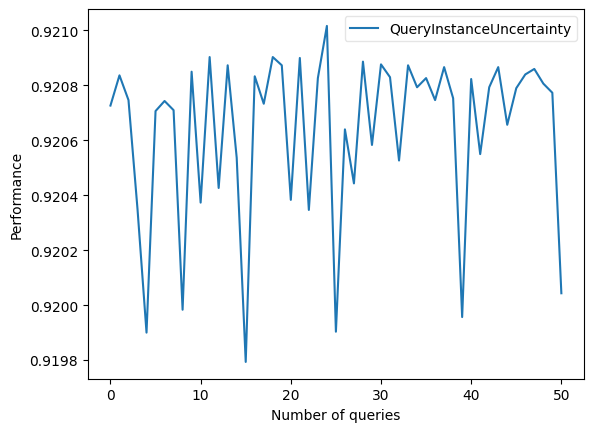

In [100]:
import collections
from collections.abc import Iterable

# Monkey patching collections.Iterable to collections.abc.Iterable
collections.Iterable = Iterable

from alipy.experiment.al_experiment import AlExperiment

al = AlExperiment(X, Y, stopping_criteria='num_of_queries', stopping_value=50)
al.split_AL()
al.set_query_strategy(strategy="QueryInstanceUncertainty", measure='least_confident')
al.set_performance_metric('accuracy_score')
al.start_query(multi_thread=True)
al.plot_learning_curve()


## Acton

In [3]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Initialize the Active Learner with Random Forest and uncertainty sampling
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_train, y_training=y_train
)

# Active learning process
n_queries = 50
for _ in range(n_queries):
    # Select the most uncertain sample
    query_idx, query_instance = learner.query(X_train)

    # Teach the learner with the selected sample
    learner.teach(X_train[query_idx], y_train[query_idx])

    # Remove the taught sample from the training data
    X_train = np.delete(X_train, query_idx, axis=0)
    y_train = np.delete(y_train, query_idx)

# Predict on the test set
y_pred = learner.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

NameError: name 'train_test_split' is not defined

# Implementation

In [ ]:
def run_experiments_synthetic(data, num_experiments=10):
    
    mean_lr = []
    mean_al_lr=[]
    mean_us_lr=[]
    mean_qbc=[]
    mean_modal=[]
    X=data[0]
    Y=data[1]
    for _ in range(num_experiments):
        
        X_train, X_test, Y_train, Y_test = train_test_split(data[0], data[1], test_size=0.3, random_state=42)
        
        
        
        clf=LogisticRegression(random_state=42)
        
        
   
        indices = np.random.choice(len(X_train), size=400, replace=False)
        X0=X_train[indices]
        Y0=Y_train[indices]
        clf.fit(X0,Y0)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(Y_test, predictions)
        mean_lr.append(accuracy)
        
        
        epsilon1, A1, eta1, time_taken1 = active_learning_with_rejection_lr(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
        eta_values1, labels1 = label_points(X_test, A1, eta1)
        accuracy_al1 = accuracy_score(Y_test, labels1)
        mean_al_lr.append(accuracy_al1)


        epsilon11, A11, eta11, time_taken11 = active_learning_with_rejection_US_lr(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
        eta_values11, labels11 = label_points(X_test, A11, eta11)
        accuracy_al11 = accuracy_score(Y_test, labels11)
        mean_us_lr.append(accuracy_al11)


        epsilon, A, eta, time_taken = active_learning_with_rejection_QBC(data, X_train, Y_train, beta=1, N1=400, d=2, c=2, M=50)
        eta_values, labels = label_points_QBC(X_test, A, eta)
        accuracy_qbc = accuracy_score(Y_test, labels)
        mean_qbc.append(accuracy_qbc)



        classifier =  LogisticRegression()
        n_initial=20
        initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
        X_initial, y_initial = X_train[initial_idx], Y_train[initial_idx]
        
        learner = ActiveLearner(
            estimator=classifier,
            query_strategy=uncertainty_sampling,
            X_training=X_initial, y_training=y_initial
        )

        n_queries = 380
        for _ in range(n_queries):
            query_idx, query_instance = learner.query(X)
            #print(query_idx)
            learner.teach(X[query_idx], Y[query_idx])

        mean_modal.append(learner.score(X_test, Y_test))


    


    mean_misclassification_error = {'lr':np.mean(mean_lr),'al_lr':np.mean(mean_al_lr), 'us_lr':np.mean(mean_us_lr),
                                    'qbc':np.mean(mean_qbc),'modAL':np.mean(mean_modal)}
    std_me={'lr':np.std(mean_lr),'al_lr':np.std(mean_al_lr),
            'us_lr':np.std(mean_us_lr),'qbc':np.std(mean_qbc),'modAL':np.std(mean_modal)}
    return mean_misclassification_error,std_me
    


In [49]:
data=[X,Y]
mean_misclassification_error,std_me = run_experiments_synthetic(data, num_experiments=10)
print(mean_misclassification_error,std_me)

{'lr': 0.9208299999999999, 'al_lr': 0.9206166666666666, 'us_lr': 0.9167900000000001, 'qbc': 0.9061200000000001, 'modAL': 0.9078733333333332} {'lr': 0.0008650561959908889, 'al_lr': 0.001610193225119968, 'us_lr': 0.003130283977178058, 'qbc': 0.007366669683257304, 'modAL': 0.010773463283044645}


# Non Synthetic Dataset

In [6]:
df=pd.read_csv(r'healthcare-dataset-stroke-data.csv')
drop_list = ['bmi','id']
df.drop(drop_list, axis=1, inplace=True)
categorical_vars = ['gender','ever_married', 'work_type','Residence_type','smoking_status']
label_encoders = {col: LabelEncoder() for col in categorical_vars}


for col in categorical_vars:
    df[col] = label_encoders[col].fit_transform(df[col])
# Split the data into training and testing sets
fraction_train = 0.8
fraction_test = 1.0 - fraction_train
df_train, df_test = train_test_split(df, train_size=fraction_train, test_size=fraction_test, random_state=42)

# Scale the data
scaler = MinMaxScaler()

# Separate features and target
y_train = df_train["stroke"]
X_train = df_train.drop(columns=["stroke"])
y_test = df_test["stroke"]
X_test = df_test.drop(columns=["stroke"])

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train=y_train.values
y_test=y_test.values


# ModAl Implementation for Non synthetic dataset

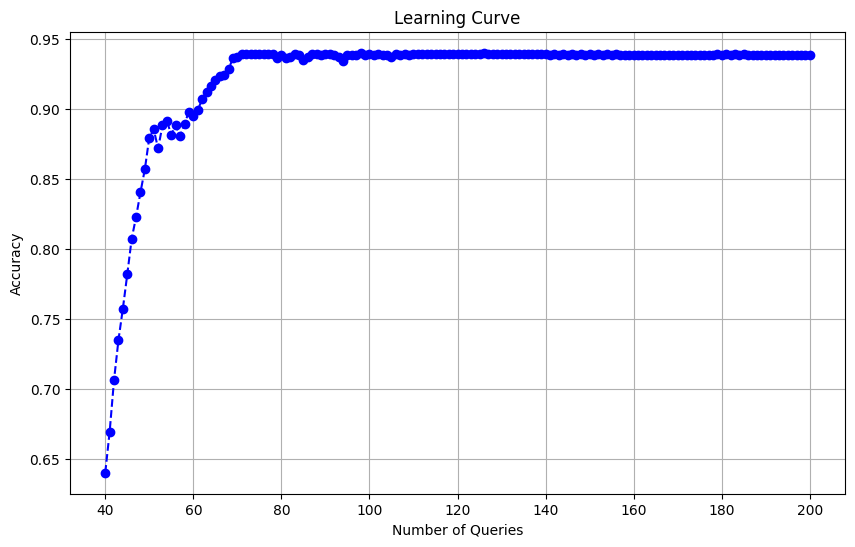

Final Accuracy after 160 queries: 0.9383561643835616


In [9]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.linear_model import LogisticRegression

# Ensure initial training data contains samples from both classes
n_initial = 40
initial_idx = []
unique_classes = np.unique(y_train)

# For each class, randomly select some instances
for cls in unique_classes:
    class_indices = np.where(y_train == cls)[0]
    selected_indices = np.random.choice(class_indices, size=n_initial // len(unique_classes), replace=False)
    initial_idx.extend(selected_indices)

# Convert initial_idx to a numpy array and ensure it is unique
initial_idx = np.array(initial_idx)
X_initial, y_initial = X_train_scaled[initial_idx], y_train[initial_idx]

# Initialize the learner
learner = ActiveLearner(
    estimator=LogisticRegression(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

# Number of queries to perform
n_queries = 160

# List to store accuracy after each query
accuracy_scores = []

# Initial accuracy on the test set
initial_accuracy = learner.score(X_test_scaled, y_test)
accuracy_scores.append(initial_accuracy)

# Active learning loop
for i in range(n_queries):
    # Query for the most uncertain instance
    query_idx, query_instance = learner.query(X_train_scaled)
    
    # Teach the learner with the newly labeled instance
    X_query = X_train_scaled[query_idx].reshape(1, -1)
    y_query = y_train[query_idx].reshape(1, )
    
    # Check if the queried data contains at least two classes
    if len(np.unique(np.concatenate([learner.y_training, y_query]))) > 1:
        learner.teach(X_query, y_query)
    
    # Calculate accuracy on the test set after each query
    accuracy = learner.score(X_test_scaled, y_test)
    accuracy_scores.append(accuracy)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(40, 40 + len(accuracy_scores)), accuracy_scores, marker='o', linestyle='--', color='blue')
plt.title('Learning Curve')
plt.xlabel('Number of Queries')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Final Accuracy
final_accuracy = accuracy_scores[-1]
print(f'Final Accuracy after {n_queries} queries: {final_accuracy}')


# Alipy for Non-synthetic 

+-------+-------------------+-------------+--------------------------+
| round | number_of_queries | time_elapse | performance (mean ± std) |
+-------+-------------------+-------------+--------------------------+
|   0   |         14        |   00:00:04  |       0.958 ± 0.00       |
|   1   |         14        |   00:00:04  |       0.953 ± 0.00       |
|   2   |         12        |   00:00:04  |       0.957 ± 0.00       |
|   3   |         10        |   00:00:03  |       0.949 ± 0.00       |
|   4   |         8         |   00:00:03  |       0.948 ± 0.00       |
|   5   |         7         |   00:00:02  |       0.959 ± 0.00       |
|   6   |         4         |   00:00:02  |       0.953 ± 0.00       |
|   7   |         2         |   00:00:01  |       0.953 ± 0.00       |
|   8   |         2         |   00:00:01  |       0.946 ± 0.00       |
|   9   |         2         |   00:00:00  |       0.955 ± 0.00       |
+-------+-------------------+-------------+--------------------------+
+-----

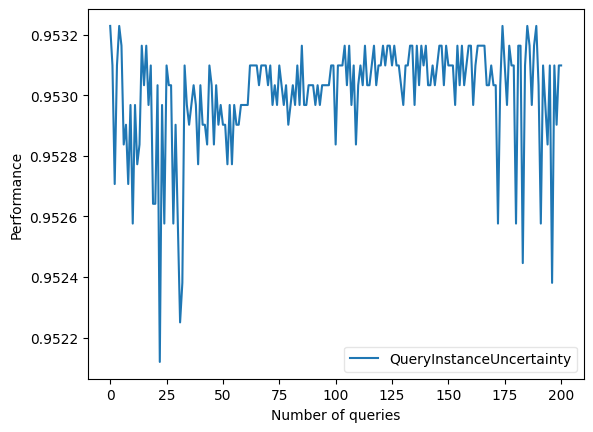

In [10]:
import collections
from collections.abc import Iterable
X_combined = np.vstack((X_train_scaled, X_test_scaled))
y_combined = np.concatenate((y_train, y_test))
# Monkey patching collections.Iterable to collections.abc.Iterable
collections.Iterable = Iterable

from alipy.experiment.al_experiment import AlExperiment

al = AlExperiment(X_combined, y_combined, stopping_criteria='num_of_queries', stopping_value=200)
al.split_AL()
al.set_query_strategy(strategy="QueryInstanceUncertainty", measure='least_confident')
al.set_performance_metric('accuracy_score')
al.start_query(multi_thread=True)
al.plot_learning_curve()
